In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.metrics import classification_report

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
! pip install -q mord
! pip install -q catboost
! pip install -q xgboost
! pip install -q lgbm

  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement lgbm (from versions: none)
ERROR: No matching distribution found for lgbm


Loading Cleaned Data

In [ ]:
data = pd.read_csv('IAS_Cleaned.csv', keep_default_na=False)
data.head()

,ID,Name,Gender,DOB,Age,Domicile,Date of Appointment,Allotment Year,Service Tenure,Source of Recruitment,...,Spec 2,Current Post,Post Type,Department,Department Type,Location,Job Status,With Effect From Date,Current Tenure,Pay Level
0,007600,Shri Pradip Kumar Tripathi,Male,1964-06-18,59,Uttar Pradesh,1987-08-24,1987,36,RR,...,Structural Engg,Secretary (Coordination),Secretary,Cabinet Secretariat,Secretariat Department,New Delhi,Active,2022-02-05 00:00:00,2.0,Level 17
1,018400,Shri Naresh Kumar,Male,1963-11-18,60,Delhi,1987-08-24,1987,36,RR,...,Public Admn,Chief Secretary,Secretary,N.A.,Secretariat Department,Delhi,Active,2022-04-21 00:00:00,2.0,Level 17
2,018800,Shri Chetan Bhushan Sanghi,Male,1965-06-26,58,Andhra Pradesh,1988-08-25,1988,35,RR,...,Hons,Financial Commissioner,Commissioner,Govt. of National capital Territory of Delhi (...,Other Department,New Delhi,Active,2021-01-04 00:00:00,3.0,Level 17
3,019002,Dr.(Ms.) Renu Sharma,Female,1964-10-19,59,Delhi,1988-08-25,1988,35,RR,...,Political Sc.,Chief Secretary to Government of Mizoram,Secretary,N.A.,Secretariat Department,Aizawl (Mizoram),Active,2021-02-11 00:00:00,3.0,Level 17
4,008200,Shri Atal Dulloo,Male,1966-10-24,57,Jammu & Kashmir,1989-08-21,1989,34,RR,...,N/A,Chief Secretary,Secretary,N.A.,Secretariat Department,Jammu & Kashmir,Active,2023-01-12 00:00:00,1.0,Level 17


In [ ]:
data.columns

Index(['ID', 'Name', 'Gender', 'DOB', 'Age', 'Domicile', 'Date of Appointment',
       'Allotment Year', 'Service Tenure', 'Source of Recruitment', 'Cadre',
       'Qual 1', 'Qual 2', 'Qual Type', 'Spec 1', 'Spec 2', 'Current Post',
       'Post Type', 'Department', 'Department Type', 'Location', 'Job Status',
       'With Effect From Date', 'Current Tenure', 'Pay Level'],
      dtype='object')

Removing single instance of target variable having only one occurence of that class

In [ ]:
ind = data[data['Pay Level'] == 'Level 18'].index
data = data.drop(index = ind)

Classifying Infrequent location values to 'other'

In [ ]:

loc = (data['Location'].value_counts())
c = loc > 100
loc = loc[c].index

data['Location'] = data['Location'].apply(lambda x: 'Other' if x not in loc else x)


Removing Irrelevant Features like ID, Name, DOB, etc.

In [ ]:
data = data.drop(columns = ['ID', 'Name', 'DOB', 'Qual 2', 'Date of Appointment', 'With Effect From Date', 'Qual 2', 'Qual 1', 'Spec 1', 'Spec 2', 'Current Post', 'Department'])
data

,Gender,Age,Domicile,Allotment Year,Service Tenure,Source of Recruitment,Cadre,Qual Type,Post Type,Department Type,Location,Job Status,Current Tenure,Pay Level
0,Male,59,Uttar Pradesh,1987,36,RR,UT,Post Graduate,Secretary,Secretariat Department,New Delhi,Active,2.0,Level 17
1,Male,60,Delhi,1987,36,RR,UT,Post Graduate,Secretary,Secretariat Department,Other,Active,2.0,Level 17
2,Male,58,Andhra Pradesh,1988,35,RR,UT,Post Graduate,Commissioner,Other Department,New Delhi,Active,3.0,Level 17
3,Female,59,Delhi,1988,35,RR,UT,Doctorate,Secretary,Secretariat Department,Other,Active,3.0,Level 17
4,Male,57,Jammu & Kashmir,1989,34,RR,UT,Graduate,Secretary,Secretariat Department,Other,Active,1.0,Level 17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5536,Male,32,Rajasthan,2023,1,RR,WB,Graduate,Trainee,Other Department,Mussorrie,Inactive,0.0,Level 10
5537,Female,29,Rajasthan,2023,1,RR,WB,Post Graduate,Trainee,Other Department,Mussorrie,Inactive,0.0,Level 10
5538,Female,25,Punjab,2023,1,RR,WB,Graduate,Trainee,Other Department,Mussorrie,Inactive,0.0,Level 10
5539,Male,30,Telangana,2023,1,RR,WB,Post Graduate,Trainee,Other Department,Mussorrie,Inactive,0.0,Level 10


Scaling Numerical Variables with MinMaxScaler

In [ ]:
# Define pipeline from earlier (without classifier)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif

scale_cols = ['Age', 'Service Tenure', 'Current Tenure']
ordinal_cols = ['Source of Recruitment', 'Qual Type', 'Job Status', 'Post Type']
onehot_cols = ['Domicile', 'Location', 'Cadre', 'Department Type', 'Gender', 'Allotment Year']

preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), scale_cols),
    ('ordinal', OrdinalEncoder(), ordinal_cols),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_cols)
])

transform_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('feature_selection', SelectKBest(score_func=mutual_info_classif, k=30))
])



In [ ]:
X = data.drop(columns = 'Pay Level')
y = data['Pay Level']

# 1. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 2. Train/val split from training set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

# 3. Fit only on training data
X_train_selected = transform_pipeline.fit_transform(X_train, y_train)

# 4. Transform validation and test data (no re-fitting!)
X_val_selected = transform_pipeline.transform(X_val)
X_test_selected = transform_pipeline.transform(X_test)


Encoding Target Variable with LabelEncoder

In [ ]:
le =  LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

pay_levels = le.inverse_transform(np.arange(len(le.classes_)))
pay_levels

array(['Level 10', 'Level 11', 'Level 12', 'Level 13', 'Level 14',
       'Level 15', 'Level 17'], dtype=object)

In [ ]:
# Fit and transform training data
X_train_selected = transform_pipeline.fit_transform(X_train, y_train)

# Step 1: Get preprocessed feature names
preprocessor = transform_pipeline.named_steps['preprocess']
feature_selector = transform_pipeline.named_steps['feature_selection']

# Get feature names from ColumnTransformer
onehot_feature_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(onehot_cols)
ordinal_feature_names = ordinal_cols
scale_feature_names = scale_cols

all_feature_names = np.concatenate([scale_feature_names, ordinal_feature_names, onehot_feature_names])

# Step 2: Get the selected feature names after SelectKBest
selected_mask = feature_selector.get_support()
selected_feature_names = all_feature_names[selected_mask]

# Step 3: Create DataFrame with selected feature names
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_feature_names, index=X_train.index)

X_val_selected = transform_pipeline.transform(X_val)
X_val_selected_df = pd.DataFrame(X_val_selected, columns=selected_feature_names, index=X_val.index)

X_test_selected = transform_pipeline.transform(X_test)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_feature_names, index=X_test.index)


In [ ]:
from mord import LogisticAT
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split

In [ ]:

from sklearn.svm import LinearSVC

class OrdinalClassifier2:
    def __init__(self, base_estimator=LinearSVC()):
        self.base = base_estimator
        self.models = []

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        self.models = []
        for threshold in self.classes_[:-1]:
            y_binary = (y > threshold).astype(int)
            model = clone(self.base)
            model.fit(X, y_binary)
            self.models.append(model)

    def predict(self, X):
        scores = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            # decision_function returns margin (signed distance from hyperplane)
            scores[:, i] = model.decision_function(X)

        # Convert scores to binary predictions, then sum
        return (scores > 0).sum(axis=1)

In [ ]:


class OrdinalClassifier:
    def __init__(self, base_estimator):
        self.base = base_estimator
        self.models = []

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        self.models = []
        for threshold in self.classes_[:-1]:
            y_binary = (y > threshold).astype(int)
            model = clone(self.base)
            model.fit(X, y_binary)
            self.models.append(model)

    def predict(self, X):
        probs = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            probs[:, i] = model.predict_proba(X)[:, 1]
        return probs.sum(axis=1).round().astype(int)

In [ ]:
# Models with hyperparameter grids
model_configs = {
    'LogisticAT': (
        LogisticAT(),  # no alpha fixed here
        {'alpha': [0.5, 1.0, 1.5]}
    ),
    'Ordinal_LGBM': (
        OrdinalClassifier(LGBMClassifier(verbose=-1)),
        {'base_estimator__n_estimators': [100, 200], 'base_estimator__max_depth': [5, 10, 15]}
    ),
    'Ordinal_SVC': (
        OrdinalClassifier2(LinearSVC(max_iter=10000)),
        {'C': [0.1, 1, 10]}
    ),
    'CatBoost': (
        CatBoostClassifier(verbose=0),
        {'iterations': [100, 200], 'learning_rate': [0.05, 0.1]}
    ),
    'RandomForest': (
        RandomForestClassifier(random_state=42),
        {'n_estimators': [100, 200], 'max_depth': [5, 10, 15]}
    ),
    'KNN': (
        KNeighborsClassifier(),
        {'n_neighbors': [5, 7, 9]}
    ),
    'XGBoost': (
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        {'n_estimators': [100, 200], 'max_depth': [5, 10, 15]}
    ),
    'LogisticRegression': (
        LogisticRegression(max_iter=1000),
        {'C': [0.1, 1, 2.5, 5]}
    )
}



In [ ]:
from time import perf_counter
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score, mean_absolute_error, precision_recall_fscore_support

qwk_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

t1 = perf_counter()
# Store results
results = []

# Evaluate all models
for name, (model, param_grid) in model_configs.items():
    if 'Ordinal_' in name:
        grid = GridSearchCV(model.base, param_grid, cv=5, scoring=qwk_scorer, n_jobs=-1)
        grid.fit(X_train_selected, y_train)
        best_params = grid.best_params_
        model.base.set_params(**best_params)
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_val_selected)
        cv_score = grid.best_score_
    else:
        grid = GridSearchCV(model, param_grid, cv=5, scoring=qwk_scorer, n_jobs=-1)
        grid.fit(X_train_selected, y_train)
        best_params = grid.best_params_
        model = grid.best_estimator_
        y_pred = model.predict(X_val_selected)
        cv_score = grid.best_score_

    acc = accuracy_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    qwk = cohen_kappa_score(y_val, y_pred, weights='quadratic')
    prec, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='weighted', zero_division=0)

    results.append({
        'Model': name,
        'Best Params': best_params,
        'CV QWK': cv_score,
        'Validation Accuracy': acc,
        'Validation MAE': mae,
        'Validation QWK': qwk,
        'Weighted Precision': prec,
        'Weighted Recall': recall,
        'Weighted F1': f1
    })

t2 = perf_counter()
print(f'Time taken: {t2-t1:.2f} seconds')

Time taken: 120.21 seconds


In [ ]:
# Final result table
results_df = pd.DataFrame(results).sort_values(by='Validation QWK', ascending=False).reset_index(drop=True)
results_df

,Model,Best Params,CV QWK,Validation Accuracy,Validation MAE,Validation QWK,Weighted Precision,Weighted Recall,Weighted F1
0,RandomForest,"{'max_depth': 15, 'n_estimators': 200}",0.965432,0.849099,0.159910,0.969135,0.853445,0.849099,0.850550
1,XGBoost,"{'max_depth': 5, 'n_estimators': 100}",0.962655,0.846847,0.162162,0.968621,0.853430,0.846847,0.848767
2,CatBoost,"{'iterations': 200, 'learning_rate': 0.1}",0.965646,0.842342,0.166667,0.968235,0.847519,0.842342,0.843465
3,Ordinal_LGBM,"{'base_estimator__max_depth': 5, 'base_estimat...",0.962143,0.837838,0.171171,0.966924,0.844115,0.837838,0.839622
4,Ordinal_SVC,{'C': 10},0.926535,0.804054,0.204955,0.960740,0.813196,0.804054,0.805864
5,LogisticRegression,{'C': 5},0.959841,0.799550,0.218468,0.955437,0.804805,0.799550,0.800992
6,LogisticAT,{'alpha': 1.5},0.956809,0.761261,0.247748,0.953097,0.773917,0.761261,0.764527
7,KNN,{'n_neighbors': 5},0.936859,0.743243,0.279279,0.941319,0.757354,0.743243,0.746463


In [ ]:
# Concatenate train + val data
X_final_train = np.concatenate([X_train_selected, X_val_selected], axis=0)
y_final_train = np.concatenate([y_train, y_val], axis=0)

# Result list
final_results = []

# Evaluate all models from results_df
for _, row in results_df.iterrows():
    name = row['Model']
    best_params = row['Best Params']

    # Instantiate model
    if name == 'LogisticAT':
        model = LogisticAT(**best_params)
    elif name == 'Ordinal_LGBM':
        model = OrdinalClassifier(LGBMClassifier(**{
            k.replace("base_estimator__", ""): v for k, v in best_params.items()
        }))
    elif name == 'Ordinal_SVC':
        model = OrdinalClassifier2(LinearSVC(**{
            k.replace("base_estimator__", ""): v for k, v in best_params.items()
        }))
    elif name == 'CatBoost':
        model = CatBoostClassifier(verbose=0, **best_params)
    elif name == 'RandomForest':
        model = RandomForestClassifier(random_state=42, **best_params)
    elif name == 'KNN':
        model = KNeighborsClassifier(**best_params)
    elif name == 'XGBoost':
        model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **best_params)
    elif name == 'LogisticRegression':
        model = LogisticRegression(max_iter=1000, **best_params)
    else:
        continue

    # Fit model on full training data
    model.fit(X_final_train, y_final_train)

    # Predict on both train and test
    y_pred_train = model.predict(X_final_train)
    y_pred_test = model.predict(X_test_selected)

    # Evaluate on both
    for dataset, y_true, y_pred in [('Train', y_final_train, y_pred_train), ('Test', y_test, y_pred_test)]:
        acc = accuracy_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
        prec, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted', zero_division=0
        )

        final_results.append({
            'Model': name,
            'Dataset': dataset,
            'Accuracy': acc,
            'MAE': mae,
            'QWK': qwk,
            'Weighted Precision': prec,
            'Weighted Recall': recall,
            'Weighted F1': f1
        })

# DataFrame
final_results_df = pd.DataFrame(final_results)
final_results_df.sort_values(by=["Dataset", "QWK", "Model"], ascending=False, inplace=True)
final_results_df.reset_index(drop=True, inplace=True)

# View
final_results_df


,Model,Dataset,Accuracy,MAE,QWK,Weighted Precision,Weighted Recall,Weighted F1
13,RandomForest,Train,0.956904,0.045126,0.991442,0.957517,0.956904,0.956967
15,XGBoost,Train,0.949684,0.052798,0.989962,0.950191,0.949684,0.949825
9,Ordinal_LGBM,Train,0.895758,0.106273,0.980907,0.898709,0.895758,0.896678
1,CatBoost,Train,0.888538,0.119585,0.976013,0.891126,0.888538,0.889272
11,Ordinal_SVC,Train,0.823105,0.185695,0.964084,0.828736,0.823105,0.824968
7,LogisticRegression,Train,0.824910,0.187726,0.962559,0.828215,0.824910,0.825987
3,KNN,Train,0.839350,0.180957,0.960548,0.842028,0.839350,0.840264
5,LogisticAT,Train,0.784747,0.224052,0.957640,0.788750,0.784747,0.786287
14,XGBoost,Test,0.867329,0.143502,0.971246,0.869741,0.867329,0.868101
12,RandomForest,Test,0.865523,0.146209,0.970149,0.870177,0.865523,0.866873


In [ ]:
import pickle

c1 = final_results_df.loc[final_results_df['Dataset'] == 'Test', :]
best_model_name = c1.loc[c1['QWK'].idxmax(), 'Model']
# print(best_model_name)

best_model = ''

for _, row in results_df.iterrows():
    name = row['Model']
    best_params = row['Best Params']

    if name == best_model_name:
          # print(name)
          model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **best_params)
          model.fit(X_final_train, y_final_train)
          break

best_model = model

with open(f"best_model_{name}.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [ ]:
import pandas as pd
import plotly.express as px

# Filter only Test data
df_test = final_results_df[final_results_df["Dataset"] == "Test"].copy()

# Bar Chart for selected metrics
bar_fig = px.bar(
    df_test,
    x="Model",
    y=["Accuracy", "QWK", "Weighted Precision", "Weighted Recall", "Weighted F1"],
    barmode="group",
    title="Model Comparison on Test Set (Bar Chart)",
    height=500
)
bar_fig.show()



In [ ]:
# Radar (Spider) Plot
radar_df = df_test.melt(
    id_vars=["Model"],
    value_vars=["Accuracy", "QWK", "Weighted Precision", "Weighted Recall", "Weighted F1"],
    var_name="Metric",
    value_name="Value"
)

radar_fig = px.line_polar(
    radar_df,
    r="Value",
    theta="Metric",
    color="Model",
    line_close=True,
    title="Model Comparison on Test Set (Radar Plot)",
    height=600
)
radar_fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Compute average metrics
metrics = ["Accuracy", "QWK", "Weighted Precision", "Weighted Recall", "Weighted F1"]
avg_df = final_results_df.groupby("Model")[metrics].mean().reset_index()

# Bar Chart
avg_bar_fig = px.bar(
    avg_df,
    x="Model",
    y=metrics,
    barmode="group",
    title="Average (Train + Test) Model Performance - Bar Chart",
    height=500
)
avg_bar_fig.show()



In [ ]:
# Radar Plot
avg_radar_df = avg_df.melt(
    id_vars=["Model"],
    value_vars=metrics,
    var_name="Metric",
    value_name="Value"
)
avg_radar_fig = px.line_polar(
    avg_radar_df,
    r="Value",
    theta="Metric",
    color="Model",
    line_close=True,
    title="Average (Train + Test) Model Performance - Radar Plot",
    height=600
)

avg_radar_fig.show()


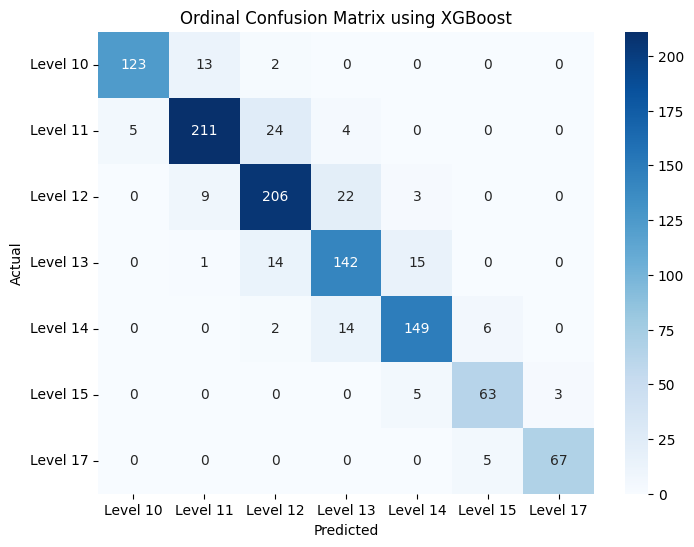

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_pred = best_model.predict(X_test_selected)

true_labels = le.inverse_transform(y_test)
predicted_labels = le.inverse_transform(test_pred)
class_names = le.classes_

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.yticks(rotation=360)
plt.title(f"Ordinal Confusion Matrix using {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()